# Decode the Secrets Behind Recommender Systems: Matrix Factorization and Completion
Name: Jie An  UNI: ja3375

## Introduction:
Matching consumers to products is an important practical problem. Recommender systems use consumers feedback about subsets of products to help recommend new things to customers that they may like. 

Two strategies for object recommendation:
- Content filtering: Use known information about the products and users to characterize its nature and make recommendations (required a lot of information difficult and expensive to collect)
- **Collaborative filtering**: Use users' past behavior (ratings) information to make future recommendations without requiring the creation of explicit profiles
    - Neighborhood Methods: compute the relationships between users (similarity score)
    - Latent Factor Models: characterize both products and users with factors inferred from the ratings patterns

### Netflix Prize
In 2006, Netflix announced the Netflix Prize, a competition to predict movie ratings on a 5-star scale. Netflix conducted this competition to find new ways to improve its recommendations. And used the root mean squared error (RMSE) between the predicted and actual rating to evaluate and quantify.

Team BellKor took over the top spot in the competition in the summer of 2007, and won the 2007 Progress Prize with the best score at the time: 8.43 percent better than Netflix. The method they introduced was a realization of latent factor models based on **Matrix Factorization**.

### Matrix Factorization
Matrix factorization is the breaking down of one matrix into a product of multiple matrices. There are many different ways to factor matrices, but singular value decomposition (SVD) is particularly useful for making recommendations.

### Matirx Completion
Borrow some notations and pictures from textbook *Chapter 4.1 Motivating Examples of Low-Rank Modeling*:
![](img/textbook.png)

Given a rating matrix $M$ with $N_1$ users and $N_2$ objects that contains every user/object pair. Users rate objects based on the quality of their experience. It is clear that it will have many missing values. We wish to predict users ratings of items that they have not yet rated. **GOAL: fill in the missing entries of $M$**.
![](img/generative.png)

Matrix $M$ here is a low-rank matrix:
- Many columns should look similar. Two movies may have correlated ratings.
- $N_1$-dimensional columns don't fill up $\mathbb{R}^{N_1}$, where $d \ll min\{N_1, N_2\}$ is the latent factors
- Matrix $M$ has fewer "degrees of freedom"

**A low-rank restriction gives hope for filling in missing data because is models correlations.**

## Technical Approach:

### Matrix Factorization via SVD
SVD is an algorithm that decomposes a matrix $M$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $M$. Mathematically, it decomposes $M$ into two unitary matrices and a diagonal matrix:
$$M = U \Sigma V^T$$
where $M$ is rating matrix, $U$ is the user "features" matrix, $\Sigma$ is the diagonal matrix of singular values, and $V^T$ is the object “features” matrix. $U$ and $V^T$ are orthogonal with $U^T U = I$, $V^TV = I$ and $\Sigma$ is diagonal with $\Sigma_{ii} \geq 0$.

### Learning Algorithm
Set $\Omega$ contains the pair $(i,j)$ that are observed, then $\Omega = \{ (i,j): M_{ij} \text{ is measured} \}$. So $(i,j) \in \Omega$ is user $i$ rated object $j$.

Let $M_0$ be the part of $M$ that is observed and $M_m$ the missing part. Then the joint likelihood
$$p(M_0|U,V) = \int p(M_0, M_m|U,V)dM_m$$
can be factorized as:
$$p(M_0, U, V) = [\prod_{(i,j) \in \Omega} p(M_{ij}|u_i,v_j)] \times [\prod_{i=1}^{N_1} p(u_i)][\prod_{j=1}^{N_2} p(v_j)]$$
The maximum a posteriori (MAP) solution for $U$ and $V$ is the maximum of the log joint likelihood:
$$U_{MAP}, V_{MAP} = \arg \max_{U,V} \sum_{(i,j) \in \Omega} \ln p(M_{ij}|u_i, v_j) + \sum_{i=1}^{N_1} \ln p(u_i) + \sum_{j=1}^{N_2} \ln p(v_j)$$
Then we want to maximize the MAP objective function $\mathcal{L}$:
$$\mathcal{L} = - \sum_{(i,j) \in \Omega} \frac{1}{2\sigma^2}||M_{ij} - u_i^Tv_j||^2 - \sum_{i=1}^{N_1}\frac{\lambda}{2}||u_i||^2 - \sum_{j=1}^{N_2}\frac{\lambda}{2}||v_j||^2 + \text{constant}$$
To update each $u_i$ and $vCa_j$, take the derivative of $\mathcal{L}$ and set to zero:
	$$\bigtriangledown _{u_i} \mathcal{L} = \sum_{j\in\Omega_{u_i}} \frac{1}{\sigma^2} (M_{ij} - u_i^Tv_j)v_j - \lambda u_i = 0$$
	$$\bigtriangledown _{v_j} \mathcal{L} = \sum_{i\in\Omega_{v_j}} \frac{1}{\sigma^2} (M_{ij} - v_j^Tu_i)u_i - \lambda v_j = 0$$
Then, we can solve for each $u_i$ and $v_j$ individually:
$$u_i = (\lambda \sigma^2 I + \sum_{j \in \Omega_{u_i}}v_jv_j^T)^{-1} (\sum_{j \in \Omega_{u_i}} M_{ij}v_j)$$
$$v_j = (\lambda \sigma^2 I + \sum_{i \in \Omega_{v_j}}u_iu_i^T)^{-1} (\sum_{i \in \Omega_{v_j}} M_{ij}u_i)$$
We cannot solve for all $u_i$ and $v_j$ at once to find the MAP solution. So we use a coordinate ascet algorithm in several iterations to update.

### MAP inference coordinate ascent algorithm
- Input: An incomplete rating matrix $M$, set $\Omega$, rank $d$
- Output: $N_1$ user locations $u_i \in \mathbb{R}^d$, and $N_2$ object locations, $v_j \in \mathbb{R}^d$
- Initialization: $u_i \text{ as } N(0,\lambda^{-1}I)$, $v_j \text{ as } N(0,\lambda^{-1}I)$

**for** each interation **do**
  - **for** $i=1,...,N_1$ **update user location**
$$u_i = (\lambda \sigma^2 I + \sum_{j \in \Omega_{u_i}}v_jv_j^T)^{-1} (\sum_{j \in \Omega_{u_i}} M_{ij}v_j)$$
  - **for** $j=1,...,N_2$ **update object location**
$$v_j = (\lambda \sigma^2 I + \sum_{i \in \Omega_{v_j}}u_iu_i^T)^{-1} (\sum_{i \in \Omega_{v_j}} M_{ij}u_i)$$

## Experiments:
### Data set: MovieLens (simplified)
This data set consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies. 
- Already de-mean the data (normalize by each users ratings mean).

In [64]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns

# Input training and testing set
rating_train = pd.read_csv('./dataset/ratings_train.csv', header=None) 
movie = pd.read_csv('./dataset/movies.txt',sep="\n", header=None)
rating_train.columns = ['user_id','movie_id','rating']
rating_test = pd.read_csv('./dataset/ratings_test.csv', header=None)
rating_test.columns = ['user_id','movie_id','rating']

index = pd.DataFrame(np.arange(1,len(movie)+1))
movie = pd.concat([index, movie], axis=1, sort=False)
movie.columns = ['movie_id','movie_name']

### Construct matrix M and test matrix

In [10]:
M = np.zeros((len(rating_train['user_id'].unique()), len(movie)))
for i in range(0, rating_train.shape[0]):
    row = rating_train.iloc[i,:]
    M[int(row[0]-1), int(row[1]-1)] = row[2]

M_test = np.zeros((len(rating_train['user_id'].unique()), len(movie)))
for i in range(0, rating_test.shape[0]):
    row = rating_test.iloc[i,:]
    M_test[int(row[0]-1), int(row[1]-1)] = row[2]

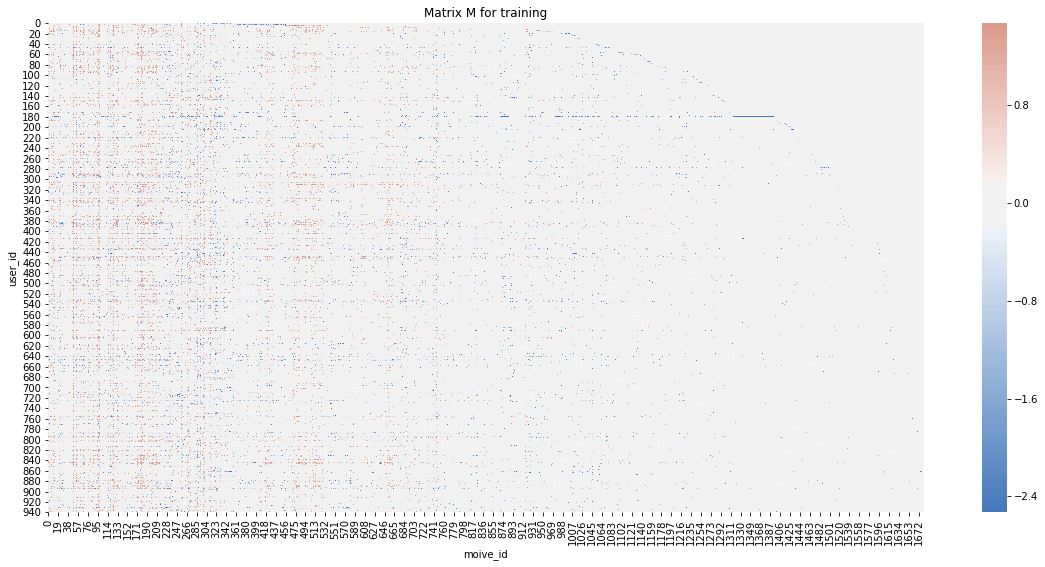

In [63]:
# visualization for training matrix
plt.figure(figsize=(21,9))
ax = sns.heatmap(
    M, 
    center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True)
plt.title('Matrix M for training')
plt.xlabel('moive_id')
plt.ylabel('user_id')
plt.show()

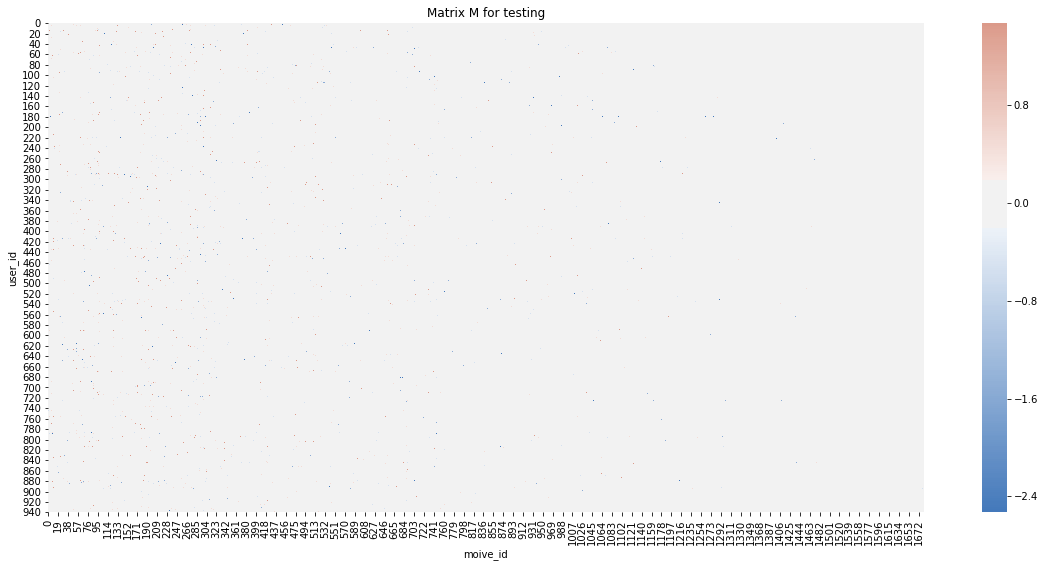

In [65]:
# visualization for testing matrix
plt.figure(figsize=(21,9))
ax = sns.heatmap(
    M_test, 
    center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True)
plt.title('Matrix M for testing')
plt.xlabel('moive_id')
plt.ylabel('user_id')
plt.show()

### Implement MAP inference coordinate ascent algorithm

In [18]:
# Implement MAP inference coordinate ascent algorithm
def matrix_factorization(M, cov, d, lambda_, num_iteration):
    """
    Return loss fuction and matrix factorization result u, v after num_iterations iteraions
    
    :param M: matrix dataset
    :param cov: initial cov (sigma_squared)
    :param d: rank
    :param lambda_: lambda
    :param num_iteration: number of iterations
    """

    #initialize   
    v = np.random.multivariate_normal([0]*M.shape[1], np.identity(M.shape[1]), size = d) #shape(10,1682)
    u = np.repeat(np.NaN,M.shape[0]*d).reshape(M.shape[0], d) #shape (943,10)

    objective_func = []
    
    for iteration in range(0,num_iteration):
        #update u
        for i in range(0,M.shape[0]):
            #select step: use select matrix to only keep vj that has ui
            select_matrix = abs(np.sign(M[i])) #(1682,)
            v_as = np.multiply(select_matrix,v) #v_after_select, shape: 10*1682
            temp = inv(np.identity(d)*cov + np.matmul(v_as,v_as.transpose())) #10*10
            Mv = np.matmul(M[i].reshape(-1,1).transpose(),v.transpose()) #Mv term
            result = np.matmul(Mv, temp) #1*10, need to insert to u(943*10)
            u[i] = result #update u row by row
 
        #update v        
        for j in range(0,M.shape[1]):
            #select step: use select matrix to only keep ui that has vj
            select_matrix2 = abs(np.sign(M[:,j])) #data[:,j]: shape(943,)
            u_as = np.multiply(select_matrix2, u.transpose()) #u after select 10*943
            temp2 = inv(np.identity(d)*cov + np.matmul(u_as,u_as.transpose())) #10*10
            Mu = np.matmul(M[:,j].reshape(-1,1).transpose(),u) #1*10
            result2 = np.matmul(Mu,temp2) #1*10          
            v[:,j] = result2 #update v column by column
        
        #loss function
        u_loss = np.sum(lambda_/2*np.square(u))
        v_loss = np.sum(lambda_/2*np.square(v))
   
        select_matrix3 = abs(np.sign(M))
        pred = np.matmul(u, v)
        subtract = np.multiply(M - pred, select_matrix3)
        subtract_norm = np.sum(np.square(subtract))/(2*cov)
        
        L = -subtract_norm - u_loss - v_loss
        objective_func.append(L)
        
    return objective_func, u, v  #u:(943,10); v:(10,1682)

In [19]:
def run_matrix_factorization_ntimes(M, n_times):
    """
    Run matrix factorization algorithm n_times times.

    """
    obj_result = []
    u_result = []
    v_result = []
    for interation in range(0, n_times):
        obj_one, u_one, v_one = matrix_factorization(M, 0.25, 10, 1, 100)
        obj_result.append(obj_one)
        u_result.append(u_one)
        v_result.append(v_one)
    return obj_result, u_result, v_result

### Define RMSE for evaluation

In [20]:
def RMSE(pred, truth):
    """
    Return RMSE between the prediction results (obtained by matrix factorization) and ground truth

    """
    subtract = np.multiply(truth - pred, abs(np.sign(truth)))
    N = np.sum(abs(np.sign(truth)))
    RMSE = np.sqrt(1/N*np.sum(np.square(subtract)))
    return RMSE

### Log joint likelihood for 10 runs

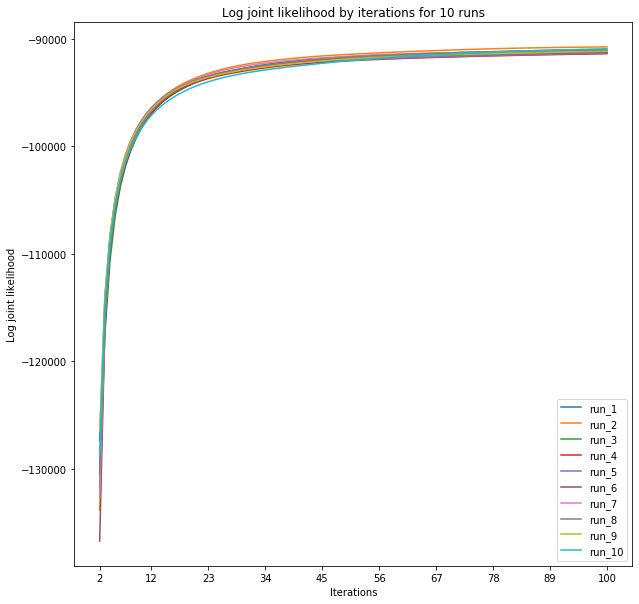

In [21]:
obj_result, u_result, v_result = run_matrix_factorization_ntimes(M, 10)

plt.figure(figsize=(10,10))
i = 1
for item in obj_result:
    plt.plot(np.arange(2,101), item[1:], label = 'run_'+str(i))
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Log joint likelihood')
    plt.title('Log joint likelihood by iterations for 10 runs')
    plt.xticks([int(x) for x in np.linspace(2,100,10)])
    i += 1
plt.show()

### RMSE for each run and pick the best run for prediction

In [66]:
RMSE_result = [] 
for i in range(0, len(u_result)):
    u = u_result[i]
    v = v_result[i]
    pred_result = np.matmul(u, v)
    rmse = RMSE(pred_result, M_test)
    RMSE_result.append(rmse)
    
obj_final = []
for i in range(0, len(obj_result)):
    obj_final.append(obj_result[i][-1])
    
d = {'run': np.arange(1,11),'final value of obj':obj_final,'RMSE':RMSE_result}
df = pd.DataFrame(d)
df.sort_values(by=['final value of obj'],ascending=False)

,run,final value of obj,RMSE
1,2,-90725.489855,1.115077
9,10,-90902.895882,1.111587
0,1,-90972.762885,1.093415
7,8,-91014.111316,1.111624
6,7,-91134.543574,1.128258
8,9,-91136.570353,1.093788
5,6,-91214.313817,1.108230
4,5,-91312.961398,1.116357
2,3,-91315.854626,1.125137
3,4,-91359.263814,1.107143


In [67]:
best_run_index = df.sort_values(by=['final value of obj'],ascending=False)['run'].index[0]
best_u = u_result[best_run_index]
best_v = v_result[best_run_index]
M_pred = np.matmul(best_u, best_v)

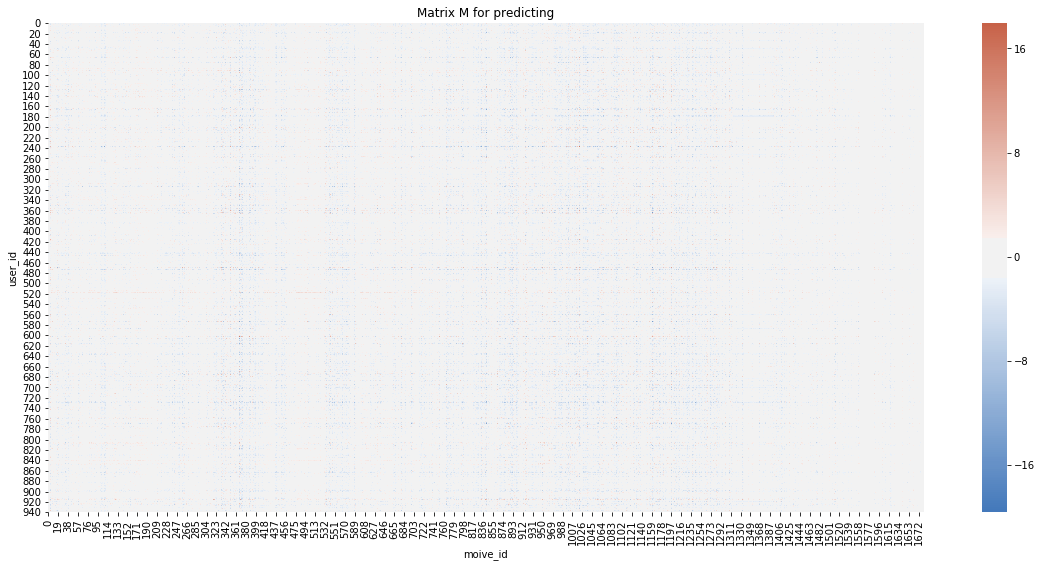

In [69]:
# visualization for predicting matrix
plt.figure(figsize=(21,9))
ax = sns.heatmap(
    M_pred, 
    center=0,
    cmap=sns.diverging_palette(250, 20, sep=20, as_cmap=True),
    square=True)
plt.title('Matrix M for predicting')
plt.xlabel('moive_id')
plt.ylabel('user_id')
plt.show()

### Play around with the prediction

#### Find the similar movies for a given one (i.e., Toy Story)
![](img/choose3.png)
According to Euclidean Distance using their respective locations $v_j$

In [72]:
def closet_movie(movie_id, best_v):
    best_v_T = best_v.transpose()
    select_movie = best_v_T[movie_id-1]

    # use dist_acc to store distance
    dist_acc = []
    for each_movie in best_v_T: # best_v_T.shape[0]=1682
        eclu_dist = np.sqrt(np.sum(np.square(select_movie - each_movie)))  # Euclidean distance
        dist_acc.append(eclu_dist)
        
    # store result as a dictionary
    d = {'movie_id':np.arange(1,1683).tolist(),'distance': dist_acc}
    return d

In [73]:
d_toystory = closet_movie(1, best_v)
d_toystory_closet = pd.DataFrame(d_toystory).sort_values(by=['distance']).head(11)
d_result = pd.concat([d_toystory_closet, movie], axis=1, join='inner')
del d_result['movie_id']
d_result

,distance,movie_name
0,0.000000,Toy Story (1995)
587,0.511122,Beauty and the Beast (1991)
94,0.540992,Aladdin (1992)
70,0.551604,"Lion King, The (1994)"
209,0.563193,Indiana Jones and the Last Crusade (1989)
86,0.631215,Searching for Bobby Fischer (1993)
583,0.656768,"Secret Garden, The (1993)"
193,0.665646,"Sting, The (1973)"
27,0.681707,Apollo 13 (1995)
163,0.682708,"Abyss, The (1989)"


#### Recommendation for a given user

![](img/rated.png)

In [84]:
userID = 12
user_row_number = userID - 1
user_data = rating_train[rating_train.user_id == (userID)]
user_full = (user_data.merge(movie, how = 'left', left_on = 'movie_id', right_on = 'movie_id').sort_values(['rating'], ascending=False))
print ('User %s has already rated %s movies.' %(userID, user_full.shape[0]))

User 12 has already rated 50 movies.


In [174]:
user_full.head(10)

,user_id,movie_id,rating,movie_name
16,12,753,1.4696,Burnt By the Sun (1994)
45,12,238,1.4696,Raising Arizona (1987)
30,12,242,1.4696,Kolya (1996)
36,12,161,1.4696,Top Gun (1986)
39,12,4,1.4696,Get Shorty (1995)
40,12,174,1.4696,Raiders of the Lost Ark (1981)
41,12,98,1.4696,"Silence of the Lambs, The (1991)"
24,12,282,1.4696,"Time to Kill, A (1996)"
23,12,318,1.4696,Schindler's List (1993)
20,12,402,1.4696,Ghost (1990)


In [165]:
pred_df = pd.DataFrame(M_pred)
sorted_user_predictions = pred_df.iloc[user_row_number].sort_values(ascending=False)
sorted_user_pred_df = pd.DataFrame(sorted_user_predictions).reset_index().rename(columns={'index': 'movie_id', 11:'rating'})
recommend_4_user = (sorted_user_pred_df.merge(movie, how = 'left', left_on = 'movie_id', right_on = 'movie_id').sort_values(['rating'], ascending=False))

unrated_list = np.setdiff1d(recommend_4_user['movie_id'].tolist(), user_full['movie_id'].tolist()) 
recommend_4_user_unrated = recommend_4_user.loc[recommend_4_user['movie_id'].isin(unrated_list)]

In [173]:
print ('Recommending the 10 highest predicted ratings movies for user %s from remaining %s unrated ones.' %(userID, unrated_list.shape[0]))
recommend_4_user_unrated.head(10)

Recommending the 10 highest predicted ratings movies for user 12 from remaining 1632 unrated ones.


,movie_id,rating,movie_name
0,771,3.441464,Johnny Mnemonic (1995)
1,1219,2.896367,"Goofy Movie, A (1995)"
2,1008,2.755474,I Shot Andy Warhol (1996)
3,368,2.724087,Bio-Dome (1996)
4,785,2.604431,Only You (1994)
5,946,2.533775,"Fox and the Hound, The (1981)"
6,1166,2.520267,Love & Human Remains (1993)
7,696,2.319934,City Hall (1996)
8,420,2.314357,Alice in Wonderland (1951)
9,250,2.284594,"Fifth Element, The (1997)"
